In [1]:
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
#from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
#import seaborn as sns

from scipy.cluster.hierarchy import dendrogram, linkage

from moments_engr import *

In [2]:
path1 = 'C:\\Users\\kdmen\\Box\\Meta_Gesture_2024\\saved_datasets\\filtered_datasets\\$BStand_EMG_df.pkl'

with open(path1, 'rb') as file:
    raw_userdef_data_df = pickle.load(file)  # (204800, 19)
 

In [3]:
print(raw_userdef_data_df.shape)
raw_userdef_data_df.head()

(204800, 19)


,Participant,Gesture_ID,Gesture_Num,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P102,pan,1,-0.362743,-0.801651,-0.383077,-0.195299,-0.203047,-0.464472,-0.276292,-0.026736,-0.873870,-1.036152,-0.580930,-0.719494,-0.502255,-1.750091,-0.127847,-0.094192
1,P102,pan,1,-0.351553,-0.775334,-0.382545,-0.154773,-0.131977,-0.295204,-0.125822,0.089679,-0.816215,-2.082635,-0.006283,-0.139439,-0.367764,-0.208084,-0.111811,-0.039009
2,P102,pan,1,-0.380825,-0.762588,-0.398388,-0.085411,0.017528,-0.205675,-0.068451,0.117076,-0.668221,-3.403064,-0.526030,-0.478294,-0.300443,0.203266,0.113300,0.004728
3,P102,pan,1,-0.366795,-0.765464,-0.374423,-0.073225,0.183172,0.009277,-0.058907,0.080977,-0.424416,-3.709413,-0.570894,-0.775155,-0.144710,-0.619539,0.146499,0.199975
4,P102,pan,1,-0.245578,-0.761283,-0.303976,-0.081947,0.224996,0.103319,-0.003929,0.041526,-0.016530,-4.075150,-0.127710,2.682791,-0.141750,-0.208404,-0.035642,0.172662


 As a preliminary step, we can simulate each user training a gesture classification model using solely their own dataset. We can then execute a pairwise comparison, where we test each user’s model and every other user’s dataset, and report the score. At this point, we can begin a agglomerative clustering procedure, by either clustering the two users with the highest corresponding scores, or by clustering all users that achieved above some minimum cross-subject classification accuracy. Then, we can repeat this procedure on the newly formed clusters, this time training a single model over all the data in the given cluster. By repeating this process until only one model remains, we can generate a dendrogram showing which users are best clustered in order to train cluster-level models. One issue with this approach is that as the clusters grow, the training sets will grow in tandem. To a limited extent, this can be offset by limiting all dataset sizes to the size of single user’s dataset and having the cluster model train on a random sample of gestures. An alternative approach would be to enforce all users into clusters of the same size each round, so that all clusters have the same dataset size, although this would artificially create many clusters. However, we also expect to have the opposite problem, as in myprevious works I have shown that cross-subject models typically perform poorly in general for these types of tasks, e.g. that training over multiple users will likely only grant modest improvements in performance, if any (especially if fixing the training dataset size). The goal of this procedure is to yield clusters for which the internal cluster model performs better than any of the intra-subject models within the cluster. Even if the internal cluster model does not outperform all intra-subject models, as long as it reduces the calibration / number of samples required from a novel user, this is still a success.

In [4]:
# STEP 1: Train a classification model on every single individual user

userdef_df = raw_userdef_data_df.groupby(['Participant', 'Gesture_ID', 'Gesture_Num']).apply(create_feature_vectors)
#output is df with particpant, gesture_ID, gesture_num and feature (holds 80 len vector)
userdef_df = userdef_df.reset_index(drop=True)

#convert Gesture_ID to numerical with new Gesture_Encoded column
label_encoder = LabelEncoder()
userdef_df['Gesture_Encoded'] = label_encoder.fit_transform(userdef_df['Gesture_ID'])

label_encoder2 = LabelEncoder()
userdef_df['Cluster_ID'] = label_encoder2.fit_transform(userdef_df['Participant'])

print(userdef_df.shape)
userdef_df.head()

(3200, 6)


,Participant,Gesture_ID,Gesture_Num,feature,Gesture_Encoded,Cluster_ID
0,P004,close,1,"[[6.079045311063784], [-7.551458873254243], [-...",0,0
1,P004,close,10,"[[5.994789910363704], [-7.978871468164499], [-...",0,0
2,P004,close,2,"[[6.010193380499154], [-7.7063875553339], [-20...",0,0
3,P004,close,3,"[[5.8212078257286874], [-7.463908156909893], [...",0,0
4,P004,close,4,"[[5.974675085061773], [-7.945111601415482], [-...",0,0


In [5]:
def train_cluster_model(userdef_df, model, cluster_ids, cluster_column='Cluster_ID', feature_column='feature', target_column='Gesture_Encoded', log_clusters=[]):
    """
    Train a specific model for each cluster in the dataset.

    Parameters:
    - userdef_df (DataFrame): The input dataframe with cluster, feature, and target data.
    - model (str or sklearn model object): The model to train. If string, it must be one of:
      ['LogisticRegression', 'SVC', 'RandomForest', 'GradientBoosting', 'KNN', 'XGBoost'].
    - cluster_column (str): Column name representing the cluster IDs.
    - feature_column (str): Column name containing feature arrays.
    - target_column (str): Column name for target labels.

    Returns:
    - model_list (list): A list of trained models, one per cluster.
    """
    
    # Mapping model names to objects
    model_map = {
        'LogisticRegression': LogisticRegression(random_state=42),
        'SVC': SVC(kernel='rbf', random_state=42),
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
        'GradientBoosting': GradientBoostingClassifier(random_state=42),
        'KNN': KNeighborsClassifier(n_neighbors=5),
        # 'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    }
    
    # Get the model object if a string is provided
    if isinstance(model, str):
        if model not in model_map:
            raise ValueError(f"Unsupported model: {model}. Choose from {list(model_map.keys())}.")
        base_model = model_map[model]
    else:
        base_model = model

    model_list = []
    num_clusters = len(cluster_ids)
    # (Existing code remains the same...)
    
    for clus_idx, cluster in enumerate(cluster_ids):
        #print(f"Training models for clus_idx {clus_idx} of {num_clusters} (ID: {cluster})")
        
        # Get data for the current cluster
        clus_trainset = userdef_df[userdef_df[cluster_column] == cluster]

        # Split into training and testing data
        X_train, _, y_train, _ = train_test_split(
            np.array(clus_trainset[feature_column]), 
            np.array(clus_trainset[target_column]), 
            test_size=0.3, 
            random_state=42, 
            stratify=np.array(clus_trainset[target_column])
        )
        X_train = np.array([x.flatten() for x in X_train])

        #if cluster in log_clusters:
        #    print(f"Progress: {clus_idx}/{num_clusters} (Training clus: {cluster})")
        #    print(f"[LOG] Trainset for clus {cluster}: Norm={np.linalg.norm(X_train):.4f}")
        #    #print(f"[LOG] Train labels for cluster {cluster}: {y_train[:3]}, Norm={np.linalg.norm(y_train):.4f}")
        
        # Train the model
        model = base_model.__class__(**base_model.get_params())
        model.fit(X_train, y_train)
        model_list.append(model)

    return model_list


def test_models_on_clusters(userdef_df, trained_clus_models_lst, cluster_ids, cluster_column='Cluster_ID', feature_column='feature', target_column='Gesture_Encoded', log_clusters=[], verbose=False):
    """
    Test trained models for each cluster on every other cluster's data with optional logging.
    """
    
    num_clusters = len(cluster_ids)
    acc_matrix = np.zeros((num_clusters, num_clusters))
    # (Existing code remains the same...)
    
    for clus_idx, cluster in enumerate(cluster_ids):
        #print(f"Testing idx/CID {clus_idx}/{cluster}")
        model = trained_clus_models_lst[clus_idx]

        for clus_idx2, cluster2 in enumerate(cluster_ids):
            clus_testset = userdef_df[userdef_df[cluster_column] == cluster2]
            _, X_test, _, y_test = train_test_split(
                np.array(clus_testset[feature_column]),
                np.array(clus_testset[target_column]),
                test_size=0.3,
                random_state=42,
                stratify=np.array(clus_testset[target_column])
            )
            X_test = np.array([x.flatten() for x in X_test])

            #if cluster in log_clusters and cluster2 in log_clusters:
            #    print(f"Progress: {clus_idx}/{num_clusters} (Model from clus: {cluster})")
            #    print(f"[LOG] Testset for clus {cluster2}: Norm={np.linalg.norm(X_test):.4f}")
            #    #print(f"[LOG] Test labels for cluster {cluster2}: {y_test[:3]}, Norm={np.linalg.norm(y_test):.4f}")
                
            acc_matrix[clus_idx, clus_idx2] = accuracy_score(y_test, model.predict(X_test))

    return acc_matrix


In [6]:
# STEP 3: Combine the datasets of the two closest users (best pairwise performance --> is it two-way??)


In [7]:
# STEP 4: Repeat STEPS 1-3 until only 1 cluster remains

In [8]:
# Data structures for logging cluster merging procedure
merge_log = []  # List of tuples: [(cluster1, cluster2, distance, new_cluster), ...]
unique_clusters_log = []  # List of lists: [list of unique clusters at each step]
# Dictionary to store self-performance over iterations
intra_cluster_performance = {}
cross_cluster_performance = {}
# Simulate cluster merging and model performance tracking
iterations = 0


# Add a set of clusters to log
log_clusters = []

# Main loop for cluster merging
while len(userdef_df['Cluster_ID'].unique()) > 1:
    #print(len(userdef_df['Cluster_ID'].unique()))

    # Log the current state of clusters
    unique_clusters_log.append(sorted(userdef_df['Cluster_ID'].unique()))
    current_cluster_ids = sorted(userdef_df['Cluster_ID'].unique())

    # Train models with logging for specified clusters
    #print("TRAIN CLUSTER MODELS")
    svc_clus_model_lst = train_cluster_model(userdef_df, "SVC", current_cluster_ids, log_clusters=log_clusters)

    # Test models with logging for specified clusters
    #print("PAIRWISE TEST CLUSTER MODELS")
    #cluster_ids = sorted(userdef_df[cluster_column].unique())  # Ensure consistent cluster ordering
    sym_acc_arr = test_models_on_clusters(userdef_df, svc_clus_model_lst, current_cluster_ids, log_clusters=log_clusters)
    if len(userdef_df['Cluster_ID'].unique()) == 2:
        print(sym_acc_arr)

    for idx, cluster_id in enumerate(current_cluster_ids):
        cross_acc_sum = 0
        cross_acc_count = 0

        for idx2, cluster_id2 in enumerate(current_cluster_ids):
            if cluster_id not in intra_cluster_performance:
                intra_cluster_performance[cluster_id] = []  # Initialize list

            if idx == idx2:  # Diagonal, so intra-cluster
                # Ensure the logic assumption holds
                if cluster_id != cluster_id2:
                    raise ValueError("This code isn't working as expected...")
                intra_cluster_performance[cluster_id].append((iterations, sym_acc_arr[idx, idx2]))
            else:  # Non-diagonal, so cross-cluster
                cross_acc_sum += sym_acc_arr[idx, idx2]
                cross_acc_count += 1
                
        # Calculate average cross-cluster accuracy
        if cross_acc_count > 0:
            avg_cross_acc = cross_acc_sum / cross_acc_count
        else:
            avg_cross_acc = None  # Handle the case where no cross-cluster pairs exist
        # Append the average cross-cluster accuracy to all relevant clusters
        if cluster_id not in cross_cluster_performance:
            cross_cluster_performance[cluster_id] = []  # Initialize list
        cross_cluster_performance[cluster_id].append((iterations, avg_cross_acc))
                
    masked_diag_array = sym_acc_arr.copy()
    np.fill_diagonal(masked_diag_array, 0.0)
    similarity_score = np.max(masked_diag_array)
    max_index = np.unravel_index(np.argmax(masked_diag_array), masked_diag_array.shape)
    row_idx_to_merge = max_index[0]
    col_idx_to_merge = max_index[1]
    # Get actual cluster IDs to merge
    row_cluster_to_merge = current_cluster_ids[row_idx_to_merge]
    col_cluster_to_merge = current_cluster_ids[col_idx_to_merge]

    # Create a new cluster ID for the merged cluster
    new_cluster_id = max(current_cluster_ids) + 1
    print(f"MERGE: {row_cluster_to_merge, col_cluster_to_merge} @ {similarity_score*100:.2f}. New cluster: {new_cluster_id}")
    # Log the merge
    merge_log.append((iterations, row_cluster_to_merge, col_cluster_to_merge, similarity_score, new_cluster_id))
    # Update the DataFrame with the new merged cluster
    userdef_df.loc[userdef_df['Cluster_ID'].isin([row_cluster_to_merge, col_cluster_to_merge]), 'Cluster_ID'] = new_cluster_id

    # Remove merged clusters from tracking (mark end with None)
    intra_cluster_performance[row_cluster_to_merge].append((iterations, None))
    intra_cluster_performance[col_cluster_to_merge].append((iterations, None))
    cross_cluster_performance[row_cluster_to_merge].append((iterations, None))
    cross_cluster_performance[col_cluster_to_merge].append((iterations, None))

    iterations += 1


MERGE: (0, 14) @ 40.00. New cluster: 32
MERGE: (18, 7) @ 36.67. New cluster: 33
MERGE: (19, 23) @ 33.33. New cluster: 34
MERGE: (20, 21) @ 33.33. New cluster: 35
MERGE: (6, 31) @ 30.00. New cluster: 36
MERGE: (36, 26) @ 30.00. New cluster: 37
MERGE: (37, 11) @ 30.00. New cluster: 38
MERGE: (38, 3) @ 30.00. New cluster: 39
MERGE: (1, 10) @ 26.67. New cluster: 40
MERGE: (2, 4) @ 26.67. New cluster: 41
MERGE: (5, 24) @ 26.67. New cluster: 42
MERGE: (8, 32) @ 26.67. New cluster: 43
MERGE: (27, 9) @ 26.67. New cluster: 44
MERGE: (28, 25) @ 26.67. New cluster: 45
MERGE: (40, 30) @ 26.67. New cluster: 46
MERGE: (29, 44) @ 25.00. New cluster: 47
MERGE: (42, 35) @ 25.00. New cluster: 48
MERGE: (46, 34) @ 25.00. New cluster: 49
MERGE: (39, 41) @ 23.33. New cluster: 50
MERGE: (50, 15) @ 23.33. New cluster: 51
MERGE: (33, 47) @ 21.11. New cluster: 52
MERGE: (13, 45) @ 20.00. New cluster: 53
MERGE: (17, 16) @ 20.00. New cluster: 54
MERGE: (48, 22) @ 20.00. New cluster: 55
MERGE: (54, 12) @ 20.00. N

## INTRA CLUSTER RESULTS

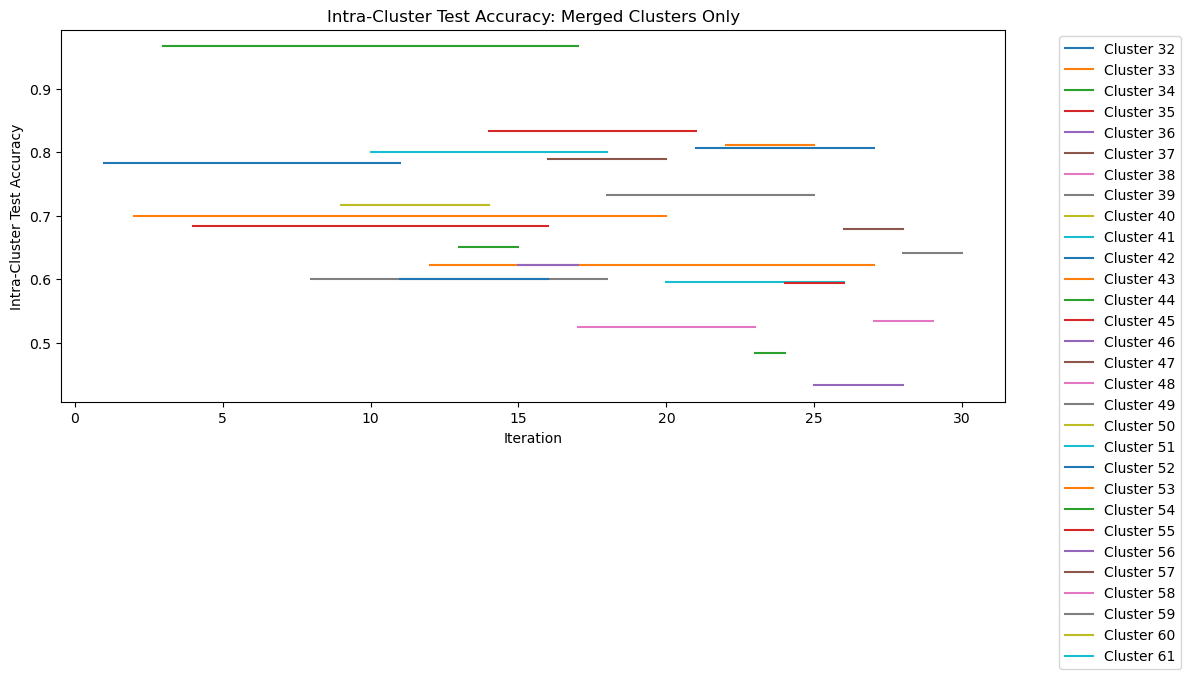

In [9]:
# Visualization
plt.figure(figsize=(12, 6))

for cluster_id in intra_cluster_performance:
    # Extract valid iterations and performance
    data = intra_cluster_performance[cluster_id]
    valid_iterations = [it for it, perf in data if perf is not None]
    valid_performance = [perf for it, perf in data if perf is not None]
    if valid_iterations[0]==0:
        continue
    #print(valid_iterations)
    #print(valid_performance)
    #print()
    plt.plot(valid_iterations, valid_performance, label=f"Cluster {cluster_id}")

plt.xlabel("Iteration")
plt.ylabel("Intra-Cluster Test Accuracy")
plt.title("Intra-Cluster Test Accuracy: Merged Clusters Only")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

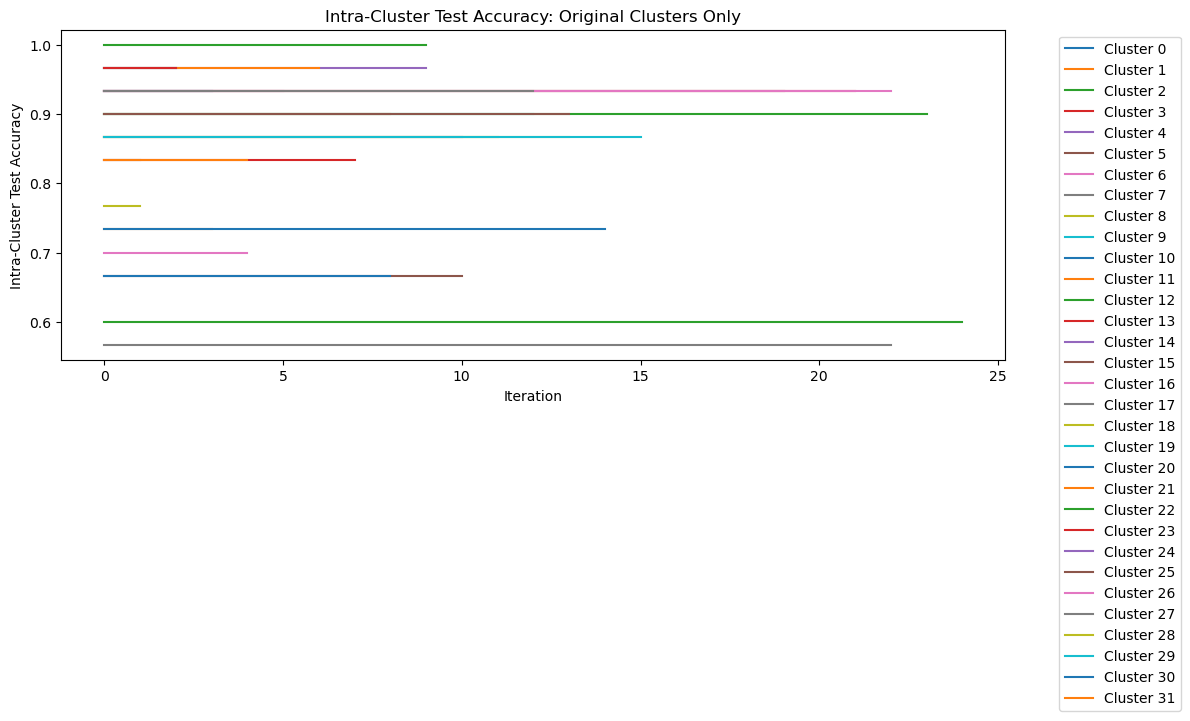

In [10]:
# Visualization
plt.figure(figsize=(12, 6))

for cluster_id in intra_cluster_performance:
    # Extract valid iterations and performance
    data = intra_cluster_performance[cluster_id]
    valid_iterations = [it for it, perf in data if perf is not None]
    valid_performance = [perf for it, perf in data if perf is not None]
    if valid_iterations[0]!=0:
        continue
    #print(valid_iterations)
    #print(valid_performance)
    #print()
    plt.plot(valid_iterations, valid_performance, label=f"Cluster {cluster_id}")

plt.xlabel("Iteration")
plt.ylabel("Intra-Cluster Test Accuracy")
plt.title("Intra-Cluster Test Accuracy: Original Clusters Only")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

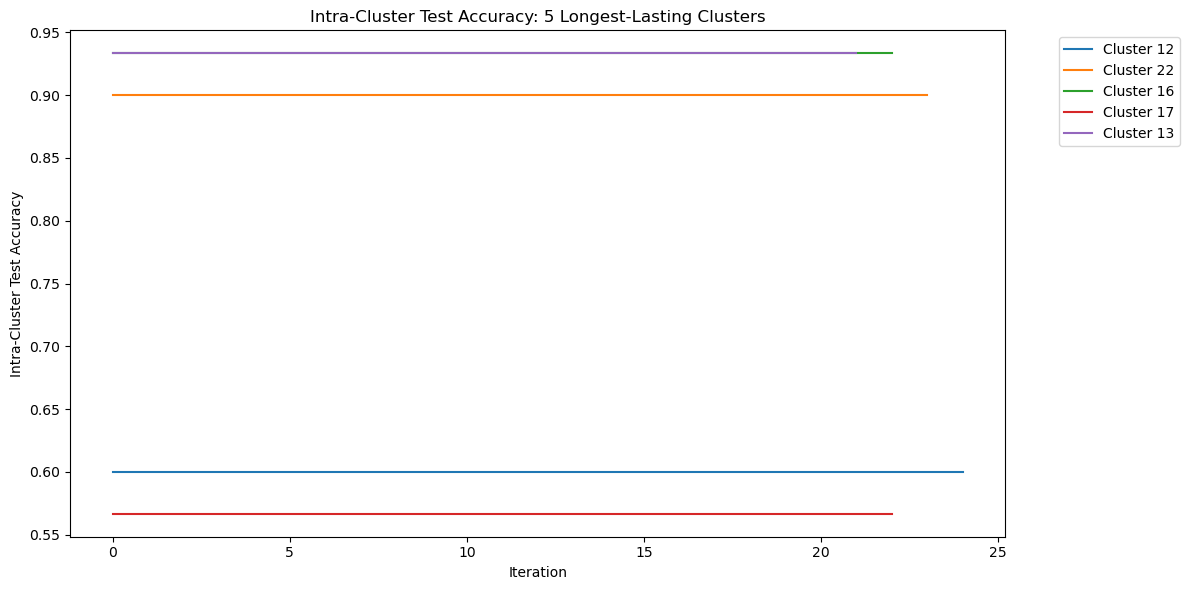

In [11]:
# Visualization
plt.figure(figsize=(12, 6))

n = 5

# Reduce number of lines (e.g., top n longest-lived clusters)
longest_clusters = sorted(intra_cluster_performance.keys(), key=lambda k: len(intra_cluster_performance[k]), reverse=True)[:n]

for cluster_id in longest_clusters:
    # Extract valid iterations and performance
    data = intra_cluster_performance[cluster_id]
    valid_iterations = [it for it, perf in data if perf is not None]
    valid_performance = [perf for it, perf in data if perf is not None]
    plt.plot(valid_iterations, valid_performance, label=f"Cluster {cluster_id}")

plt.xlabel("Iteration")
plt.ylabel("Intra-Cluster Test Accuracy")
plt.title(f"Intra-Cluster Test Accuracy: {n} Longest-Lasting Clusters")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

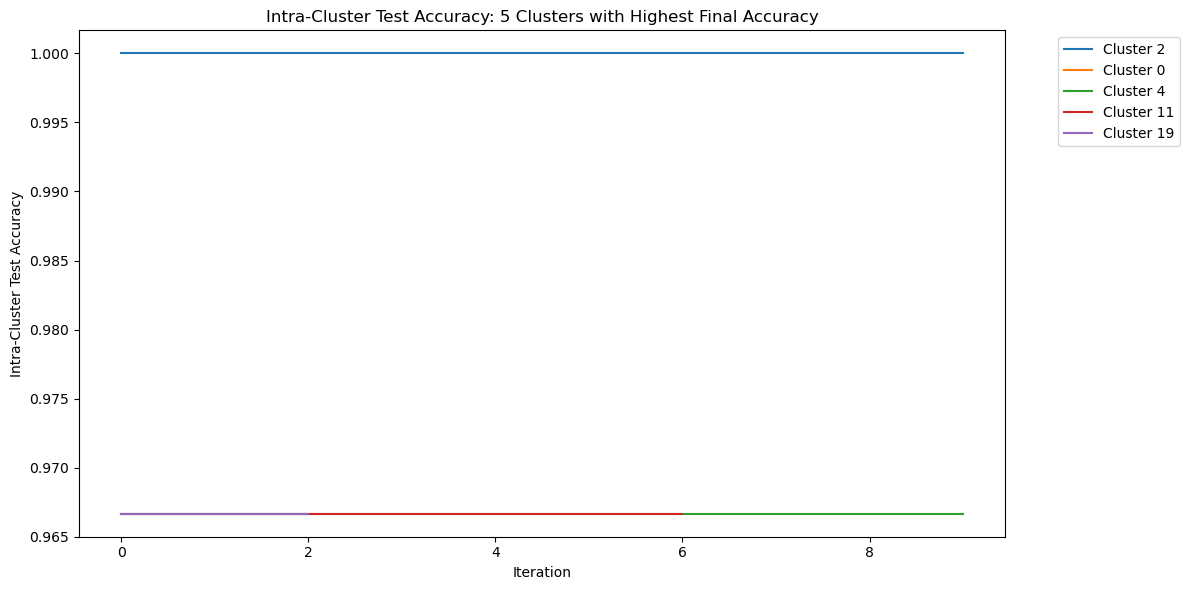

In [12]:
# Visualization
plt.figure(figsize=(12, 6))

n = 5  # Number of clusters to plot

# Find clusters with the highest final accuracies
highest_final_accuracy_clusters = sorted(
    intra_cluster_performance.keys(), 
    key=lambda k: max([perf for it, perf in intra_cluster_performance[k] if perf is not None], default=0), 
    reverse=True
)[:n]

# Plot the performance curves for these clusters
for cluster_id in highest_final_accuracy_clusters:
    # Extract valid iterations and performance
    data = intra_cluster_performance[cluster_id]
    valid_iterations = [it for it, perf in data if perf is not None]
    valid_performance = [perf for it, perf in data if perf is not None]
    plt.plot(valid_iterations, valid_performance, label=f"Cluster {cluster_id}")

plt.xlabel("Iteration")
plt.ylabel("Intra-Cluster Test Accuracy")
plt.title(f"Intra-Cluster Test Accuracy: {n} Clusters with Highest Final Accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## CROSS CLUSTER RESULTS

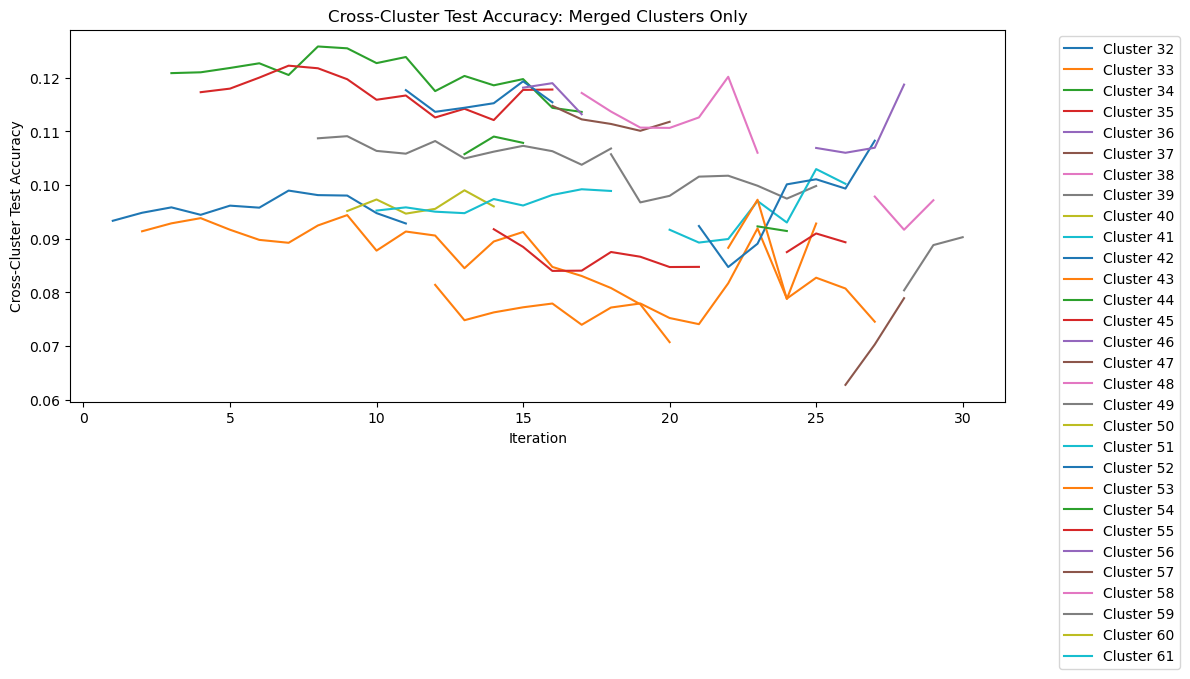

In [13]:
# Visualization
plt.figure(figsize=(12, 6))

for cluster_id in cross_cluster_performance:
    # Extract valid iterations and performance
    data = cross_cluster_performance[cluster_id]
    valid_iterations = [it for it, perf in data if perf is not None]
    valid_performance = [perf for it, perf in data if perf is not None]
    if valid_iterations[0]==0:
        continue
    #print(valid_iterations)
    #print(valid_performance)
    #print()
    plt.plot(valid_iterations, valid_performance, label=f"Cluster {cluster_id}")

plt.xlabel("Iteration")
plt.ylabel("Cross-Cluster Test Accuracy")
plt.title("Cross-Cluster Test Accuracy: Merged Clusters Only")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

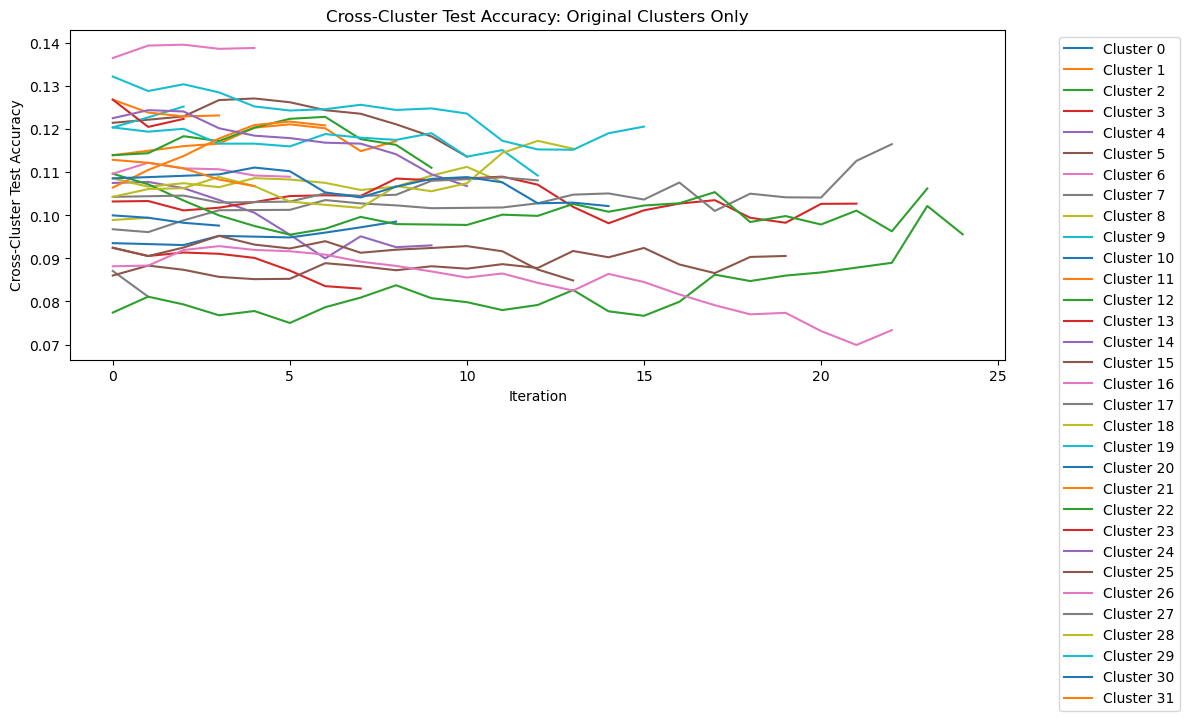

In [14]:
# Visualization
plt.figure(figsize=(12, 6))

for cluster_id in cross_cluster_performance:
    # Extract valid iterations and performance
    data = cross_cluster_performance[cluster_id]
    valid_iterations = [it for it, perf in data if perf is not None]
    valid_performance = [perf for it, perf in data if perf is not None]
    if valid_iterations[0]!=0:
        continue
    #print(valid_iterations)
    #print(valid_performance)
    #print()
    plt.plot(valid_iterations, valid_performance, label=f"Cluster {cluster_id}")

plt.xlabel("Iteration")
plt.ylabel("Cross-Cluster Test Accuracy")
plt.title("Cross-Cluster Test Accuracy: Original Clusters Only")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

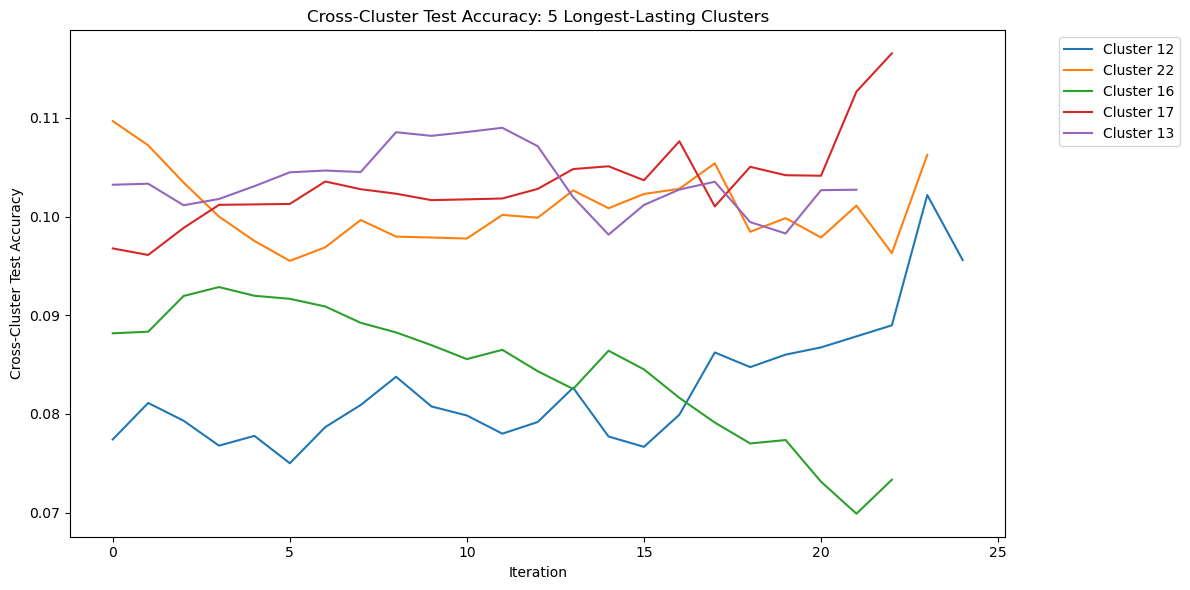

In [15]:
# Visualization
plt.figure(figsize=(12, 6))

n = 5

# Reduce number of lines (e.g., top n longest-lived clusters)
longest_clusters = sorted(cross_cluster_performance.keys(), key=lambda k: len(cross_cluster_performance[k]), reverse=True)[:n]

for cluster_id in longest_clusters:
    # Extract valid iterations and performance
    data = cross_cluster_performance[cluster_id]
    valid_iterations = [it for it, perf in data if perf is not None]
    valid_performance = [perf for it, perf in data if perf is not None]
    plt.plot(valid_iterations, valid_performance, label=f"Cluster {cluster_id}")

plt.xlabel("Iteration")
plt.ylabel("Cross-Cluster Test Accuracy")
plt.title(f"Cross-Cluster Test Accuracy: {n} Longest-Lasting Clusters")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

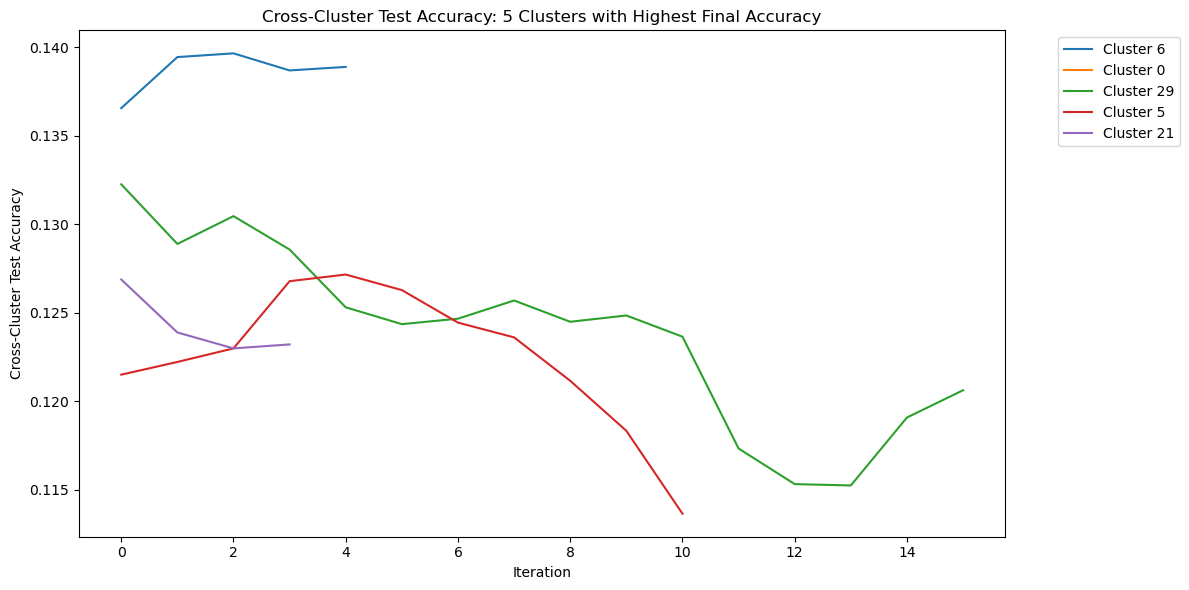

In [16]:
# Visualization
plt.figure(figsize=(12, 6))

n = 5  # Number of clusters to plot

# Find clusters with the highest final accuracies
highest_final_accuracy_clusters = sorted(
    cross_cluster_performance.keys(), 
    key=lambda k: max([perf for it, perf in cross_cluster_performance[k] if perf is not None], default=0), 
    reverse=True
)[:n]

# Plot the performance curves for these clusters
for cluster_id in highest_final_accuracy_clusters:
    # Extract valid iterations and performance
    data = cross_cluster_performance[cluster_id]
    valid_iterations = [it for it, perf in data if perf is not None]
    valid_performance = [perf for it, perf in data if perf is not None]
    plt.plot(valid_iterations, valid_performance, label=f"Cluster {cluster_id}")

plt.xlabel("Iteration")
plt.ylabel("Cross-Cluster Test Accuracy")
plt.title(f"Cross-Cluster Test Accuracy: {n} Clusters with Highest Final Accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [17]:
assert(False)

AssertionError: 

In [ ]:
# Data structures for logging cluster merging procedure
merge_log = []  # List of tuples: [(cluster1, cluster2, distance, new_cluster), ...]
unique_clusters_log = []  # List of lists: [list of unique clusters at each step]

# Dictionary to store self-performance over iterations
cluster_performance = {}
# Simulate cluster merging and model performance tracking
iterations = 0

while len(userdef_df['Cluster_ID'].unique()) > 1:
    print(len(userdef_df['Cluster_ID'].unique()))
    
    # Log the current state of clusters
    unique_clusters_log.append(sorted(userdef_df['Cluster_ID'].unique()))
    # Map indices to cluster IDs
    ## TODO: I am not sure if this should be sorted or not...
    current_cluster_ids = sorted(userdef_df['Cluster_ID'].unique())
    
    # Train models and test similarities
    print("TRAIN CLUSTER MODELS")
    svc_clus_model_lst = train_cluster_model(userdef_df, "SVC")
    print("PAIRWISE TEST CLUSTER MODELS")
    sym_acc_arr = test_models_on_clusters(userdef_df, svc_clus_model_lst)
    if len(userdef_df['Cluster_ID'].unique())==2:
        print(sym_acc_arr)
        
    # Update the cluster performance log with diagonal 
    print("LOG DIAGONAL INTRA-CLUSTER")
    diagonal_values = np.diag(sym_acc_arr)  # sym_acc_arr is the similarity matrix
    # Update performance logs
    for idx, cluster_id in enumerate(current_cluster_ids):
        print(f"Testing models for idx {idx} of {len(current_cluster_ids)} (ID: {cluster_id})")
        if cluster_id not in cluster_performance:
            cluster_performance[cluster_id] = []  # Initialize list
        cluster_performance[cluster_id].append((iterations, diagonal_values[idx]))
        
    #print(f"max pairwise acc {np.max(sym_acc_arr)} @ (flattened?) index {np.argmax(sym_acc_arr)}")
    # Find the most similar clusters to merge
    # extract_top_n_highest_pairs returning 0.0... pretty sure that is wrong
    #top_values, row_col_indices = extract_top_n_highest_pairs(sym_acc_arr)
    #row_idx_to_merge = row_col_indices[0][0]
    #col_idx_to_merge = row_col_indices[1][0]
    #similarity_score = top_values[0]
    # Simpler approach:
    masked_diag_array = sym_acc_arr.copy()
    np.fill_diagonal(masked_diag_array, 0.0)
    similarity_score = np.max(masked_diag_array)
    max_index = np.unravel_index(np.argmax(masked_diag_array), masked_diag_array.shape)
    row_idx_to_merge = max_index[0]
    col_idx_to_merge = max_index[1]
    # Get actual cluster IDs to merge
    row_cluster_to_merge = current_cluster_ids[row_idx_to_merge]
    col_cluster_to_merge = current_cluster_ids[col_idx_to_merge]
    
    # Create a new cluster ID for the merged cluster
    new_cluster_id = max(current_cluster_ids) + 1
    print(f"MERGE: {row_cluster_to_merge, col_cluster_to_merge} @ {similarity_score*100:.2f}. New cluster: {new_cluster_id}")
    print()
    # Log the merge
    merge_log.append((iterations, row_cluster_to_merge, col_cluster_to_merge, similarity_score, new_cluster_id))
    # Update the DataFrame with the new merged cluster
    userdef_df.loc[userdef_df['Cluster_ID'].isin([row_cluster_to_merge, col_cluster_to_merge]), 'Cluster_ID'] = new_cluster_id

    # Remove merged clusters from tracking
    cluster_performance[row_cluster_to_merge].append((iterations, None))  # Mark end
    cluster_performance[col_cluster_to_merge].append((iterations, None))  # Mark end
    iterations += 1

In [ ]:
merge_log

In [ ]:
# Not useful... merged at the same heights mostly...

# Convert merge_log to a linkage matrix
#linkage_matrix = []
#cluster_sizes = {cluster: 1 for cluster in unique_clusters_log[0]}  # Initialize cluster sizes
#
#for cluster1, cluster2, distance, new_cluster in merge_log:
#    size1 = cluster_sizes.pop(cluster1)
#    size2 = cluster_sizes.pop(cluster2)
#    cluster_sizes[new_cluster] = size1 + size2
#    linkage_matrix.append([cluster1, cluster2, distance, size1 + size2])
#
#linkage_matrix = np.array(linkage_matrix)
#
# Plot the dendrogram
#plt.figure(figsize=(10, 6))
#dendrogram(linkage_matrix, labels=unique_clusters_log[0])
#plt.title("Dendrogram of Cluster Merging")
#plt.xlabel("Cluster ID")
#plt.ylabel("Similarity Score (1 - Distance)")
#plt.show()


In [ ]:
# Visualization
plt.figure(figsize=(12, 6))

for cluster_id in cluster_performance:
    # Extract valid iterations and performance
    data = cluster_performance[cluster_id]
    valid_iterations = [it for it, perf in data if perf is not None]
    valid_performance = [perf for it, perf in data if perf is not None]
    if valid_iterations[0]==0:
        continue
    #print(valid_iterations)
    #print(valid_performance)
    #print()
    plt.plot(valid_iterations, valid_performance, label=f"Cluster {cluster_id}")

plt.xlabel("Iteration")
plt.ylabel("Intra-Cluster Test Accuracy")
plt.title("Intra-Cluster Test Accuracy: Merged Clusters Only")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Visualization
plt.figure(figsize=(12, 6))

for cluster_id in cluster_performance:
    # Extract valid iterations and performance
    data = cluster_performance[cluster_id]
    valid_iterations = [it for it, perf in data if perf is not None]
    valid_performance = [perf for it, perf in data if perf is not None]
    if valid_iterations[0]!=0:
        continue
    #print(valid_iterations)
    #print(valid_performance)
    #print()
    plt.plot(valid_iterations, valid_performance, label=f"Cluster {cluster_id}")

plt.xlabel("Iteration")
plt.ylabel("Intra-Cluster Test Accuracy")
plt.title("Intra-Cluster Test Accuracy: Original Clusters Only")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Visualization
plt.figure(figsize=(12, 6))

n = 5

# Reduce number of lines (e.g., top n longest-lived clusters)
longest_clusters = sorted(cluster_performance.keys(), key=lambda k: len(cluster_performance[k]), reverse=True)[:n]

for cluster_id in longest_clusters:
    # Extract valid iterations and performance
    data = cluster_performance[cluster_id]
    valid_iterations = [it for it, perf in data if perf is not None]
    valid_performance = [perf for it, perf in data if perf is not None]
    plt.plot(valid_iterations, valid_performance, label=f"Cluster {cluster_id}")

plt.xlabel("Iteration")
plt.ylabel("Intra-Cluster Test Accuracy")
plt.title(f"Intra-Cluster Test Accuracy: {n} Longest-Lasting Clusters")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Visualization
plt.figure(figsize=(12, 6))

n = 5  # Number of clusters to plot

# Find clusters with the highest final accuracies
highest_final_accuracy_clusters = sorted(
    cluster_performance.keys(), 
    key=lambda k: max([perf for it, perf in cluster_performance[k] if perf is not None], default=0), 
    reverse=True
)[:n]

# Plot the performance curves for these clusters
for cluster_id in highest_final_accuracy_clusters:
    # Extract valid iterations and performance
    data = cluster_performance[cluster_id]
    valid_iterations = [it for it, perf in data if perf is not None]
    valid_performance = [perf for it, perf in data if perf is not None]
    plt.plot(valid_iterations, valid_performance, label=f"Cluster {cluster_id}")

plt.xlabel("Iteration")
plt.ylabel("Intra-Cluster Test Accuracy")
plt.title(f"Intra-Cluster Test Accuracy: {n} Clusters with Highest Final Accuracy")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# Helper function to compute statistics for clusters
def compute_statistics(cluster_data, description):
    """
    Compute and print summary statistics for given cluster data.

    Parameters:
        cluster_data (dict): Dictionary where keys are cluster IDs and values are [(iteration, accuracy), ...].
        description (str): Description of the dataset (e.g., intra-cluster or cross-cluster).
    """
    print(f"\n=== Statistics for {description} ===")
    
    # Separate clusters that start at iteration 0 and others
    starts_at_zero = {k: v for k, v in cluster_data.items() if v[0][0] == 0}
    starts_later = {k: v for k, v in cluster_data.items() if v[0][0] != 0}
    
    # Summary function
    def summarize_clusters(clusters, label):
        print(f"\nClusters {label}:")
        print(f"Count: {len(clusters)}")
        print()
        
        for cluster_id, data in clusters.items():
            iterations = [it for it, perf in data if perf is not None]
            performances = [perf for it, perf in data if perf is not None]
            if not performances:
                continue  # Skip clusters with no valid data
            
            start_acc = performances[0]
            final_acc = performances[-1]
            duration = len(iterations)
            mean_acc = np.mean(performances)
            std_acc = np.std(performances)
            
            # Print statistics for the cluster
            print(f"Cluster {cluster_id}:")
            print(f"  Started at Iteration: {iterations[0]}")
            print(f"  Duration (Iterations): {duration}")
            print(f"  Start Accuracy: {start_acc:.3f}")
            print(f"  Final Accuracy: {final_acc:.3f}")
            print(f"  Mean Accuracy: {mean_acc:.3f}")
            print(f"  Std Dev Accuracy: {std_acc:.3f}")
            print(f"  Performance {'Improved' if final_acc > start_acc else 'Worsened'} over time.")
            print()
        
        # Compute overall trends
        if clusters:
            durations = [len([it for it, perf in data if perf is not None]) for data in clusters.values()]
            improvements = [
                1 if (perf[-1] > perf[0]) else -1 for data in clusters.values()
                if (perf := [perf for it, perf in data if perf is not None])
            ]
            print("\nOverall Trends:")
            print(f"  Avg Duration: {np.mean(durations):.2f}")
            print(f"  Std Duration: {np.std(durations):.2f}")
            print(f"  Improvement (1=Improved, -1=Worsened): Mean={np.mean(improvements):.2f}")

    # Summarize clusters starting at iteration 0
    summarize_clusters(starts_at_zero, "Starting at Iteration 0")
    # Summarize clusters starting later
    summarize_clusters(starts_later, "Starting Later")

In [ ]:
# Intra-cluster accuracy statistics (diagonal)
print("Processing Intra-Cluster Accuracies...")
compute_statistics(cluster_performance, "Intra-Cluster Accuracies")

In [ ]:
# Cross-cluster accuracy statistics (non-diagonal)
print("\nProcessing Cross-Cluster Accuracies...")
# Assuming `cross_cluster_performance` is structured like `cluster_performance` but for non-diagonal accuracies
compute_statistics(cluster_performance, "Cross-Cluster Accuracies")


In [ ]:
def track_merge_improvements(merge_log, cluster_performance, description, hardcoded_final_new_cluster=62):
    """
    Track and print merges that improve accuracy.

    Parameters:
        merge_log (list): List of tuples [(iteration, cluster1, cluster2, new_cluster)].
        cluster_performance (dict): Cluster performance dictionary {cluster_id: [(iteration, accuracy), ...]}.
        description (str): Description of the dataset (e.g., intra-cluster or cross-cluster).
    """
    print(f"\n=== Merge Improvement Analysis for {description} ===")
    
    #for iteration, cluster1, cluster2, new_cluster in merge_log:
    for iteration, cluster1, cluster2, merge_acc, new_cluster in merge_log:
    #for log_index, (iteration, cluster1, cluster2, merge_acc, new_cluster) in enumerate(merge_log):
        print(f"Processing merge log entry {iteration}:")
        print(f"{iteration}, {cluster1}, {cluster2}, {merge_acc}, {new_cluster}")
        if new_cluster==hardcoded_final_new_cluster:
            continue
            
        # Get final accuracies before merge
        c1_performance = [perf for it, perf in cluster_performance[cluster1] if it == iteration - 1]
        c2_performance = [perf for it, perf in cluster_performance[cluster2] if it == iteration - 1]
        new_performance = [perf for it, perf in cluster_performance[new_cluster] if it == 0]  # was iteration
        
        # Ensure we have valid performances
        if not c1_performance or not c2_performance or not new_performance:
            print("FAIL")
            print(f"{c1_performance}, {c2_performance}, {new_performance}")
            print()
            continue
        
        print("Made it!")
        
        c1_final_acc = c1_performance[0]
        c2_final_acc = c2_performance[0]
        new_acc = new_performance[0]
        
        # Check if the new cluster has improved accuracy
        if new_acc > max(c1_final_acc, c2_final_acc):
            print(f"Iteration {iteration}: Merge Improved Accuracy")
            print(f"  Cluster {cluster1}: Final Accuracy = {c1_final_acc:.3f}")
            print(f"  Cluster {cluster2}: Final Accuracy = {c2_final_acc:.3f}")
            print(f"  New Cluster {new_cluster}: Accuracy = {new_acc:.3f}")
        else:
            print(f"No improvement in {description} accuracy...")


In [ ]:
def track_merge_improvements(merge_log, cluster_performance, description, hardcoded_final_new_cluster=62):
    """
    Track and print merges that improve accuracy.

    Parameters:
        merge_log (list): List of tuples [(iteration, cluster1, cluster2, new_cluster)].
        cluster_performance (dict): Cluster performance dictionary {cluster_id: [(iteration, accuracy), ...]}.
        description (str): Description of the dataset (e.g., intra-cluster or cross-cluster).
    """
    print(f"\n=== Merge Improvement Analysis for {description} ===")

    for iteration, cluster1, cluster2, merge_acc, new_cluster in merge_log:
        print(f"\nProcessing merge log entry for iteration {iteration}:")
        print(f"  Cluster1: {cluster1}, Cluster2: {cluster2}, New Cluster: {new_cluster}, Merge Acc: {merge_acc}")
        
        # Check for hardcoded cluster exclusion
        if new_cluster == hardcoded_final_new_cluster:
            print(f"  Skipping hardcoded final new cluster {new_cluster}.")
            continue

        # Check if clusters exist in cluster_performance
        if cluster1 not in cluster_performance:
            print(f"  Cluster {cluster1} not found in cluster_performance.")
            continue
        if cluster2 not in cluster_performance:
            print(f"  Cluster {cluster2} not found in cluster_performance.")
            continue
        if new_cluster not in cluster_performance:
            print(f"  New cluster {new_cluster} not found in cluster_performance.")
            continue

        # Get performance at relevant iterations
        c1_performance = [perf for it, perf in cluster_performance[cluster1] if it == iteration - 1]
        c2_performance = [perf for it, perf in cluster_performance[cluster2] if it == iteration - 1]
        new_performance = [perf for it, perf in cluster_performance[new_cluster] if it == 0]

        # Debugging iteration values and performances
        print(f"  Cluster1 performance at iteration {iteration - 1}: {c1_performance}")
        print(f"  Cluster2 performance at iteration {iteration - 1}: {c2_performance}")
        print(f"  New cluster performance at iteration {iteration}: {new_performance}")

        # Check if any performance data is missing
        if not c1_performance or not c2_performance or not new_performance:
            print("  Missing performance data, skipping this entry.")
            continue

        # Extract final accuracies
        c1_final_acc = c1_performance[0]
        c2_final_acc = c2_performance[0]
        new_acc = new_performance[0]

        # Check if new cluster improves accuracy
        if new_acc > max(c1_final_acc, c2_final_acc):
            print(f"  Improvement detected!")
            print(f"    Cluster {cluster1}: Final Accuracy = {c1_final_acc:.3f}")
            print(f"    Cluster {cluster2}: Final Accuracy = {c2_final_acc:.3f}")
            print(f"    New Cluster {new_cluster}: Accuracy = {new_acc:.3f}")
        else:
            print(f"  No improvement in {description} accuracy.")



In [ ]:
def track_merge_improvements(merge_log):
    """
    Processes a merge log to track the performance of clusters over iterations.
    
    Args:
        merge_log (list of dict): A list where each entry is a dictionary representing 
                                  the details of a merge operation, including the clusters involved
                                  and their respective performances.
                                  
    Returns:
        dict: A dictionary mapping cluster IDs to their performance history.
    """
    # Dictionary to store the performance history of each cluster
    cluster_performance = {}
    
    for iteration, entry in enumerate(merge_log):
        # Extracting merge details
        cluster1 = entry["cluster1"]
        cluster2 = entry["cluster2"]
        new_cluster = entry["new_cluster"]
        pairwise_acc = entry["pairwise_acc"]
        cluster1_perf = entry["cluster1_perf"]
        cluster2_perf = entry["cluster2_perf"]
        new_cluster_perf = entry["new_cluster_first_perf"]
        
        #print(f"Processing merge log entry for iteration {iteration}:")
        #print(f"  Cluster1: {cluster1}, Cluster2: {cluster2}, New Cluster: {new_cluster}, Pairwise Acc: {pairwise_acc}")
        # Displaying performances of clusters involved in the merge
        #print(f"  Cluster1 performance: {cluster1_perf}")
        #print(f"  Cluster2 performance: {cluster2_perf}")
        # Adding the new performance entry for the new cluster
        #print(f"  New cluster first performance: {new_cluster_perf}")
        
        # Update performance history for Cluster 1
        if cluster1 not in cluster_performance:
            cluster_performance[cluster1] = []
        cluster_performance[cluster1].extend(cluster1_perf)
        
        # Update performance history for Cluster 2
        if cluster2 not in cluster_performance:
            cluster_performance[cluster2] = []
        cluster_performance[cluster2].extend(cluster2_perf)
        
        # Add the new cluster's first performance
        if new_cluster not in cluster_performance:
            cluster_performance[new_cluster] = []
        cluster_performance[new_cluster].append(new_cluster_perf)
        
        # Mark the end of this iteration's performance with None for all active clusters
        for cluster in [cluster1, cluster2, new_cluster]:
            cluster_performance[cluster].append((iteration, None))
    
    return cluster_performance

In [ ]:
def process_merge_log(merge_log, cluster_performance):
    """
    Process merge log entries and fetch the very first accuracy of the new cluster.

    Args:
        merge_log (list of tuples): Each tuple contains merge details for an iteration.
        cluster_performance (dict): A dictionary mapping cluster IDs to a list of accuracies.

    Returns:
        list of dicts: Processed merge log entries with new cluster performance.
    """
    processed_log = []

    for entry in merge_log:
        # Unpack tuple values
        iteration, cluster1, cluster2, pairwise_acc, new_cluster = entry

        # Fetch performance data
        cluster1_perf = cluster_performance.get(cluster1, [])
        cluster2_perf = cluster_performance.get(cluster2, [])
        new_cluster_perf = cluster_performance.get(new_cluster, [])

        # Query the first iteration's accuracy for the new cluster
        new_cluster_first_perf = new_cluster_perf[0] if new_cluster_perf else None

        # Log processing details
        print(f"Processing merge log entry for iteration {iteration}:")
        print(f"  Cluster1: {cluster1}, Cluster2: {cluster2}, New Cluster: {new_cluster}, Pairwise Acc: {pairwise_acc}")
        print(f"  Cluster1 performance: {cluster1_perf}")
        print(f"  Cluster2 performance: {cluster2_perf}")
        print(f"  New cluster first performance: {new_cluster_first_perf}")

        if new_cluster_first_perf is None:
            print("  Missing performance data for the new cluster, skipping this entry.")
            continue

        # Add processed entry to the results
        processed_log.append({
            "iteration": iteration,
            "cluster1": cluster1,
            "cluster2": cluster2,
            "new_cluster": new_cluster,
            "pairwise_acc": pairwise_acc,
            "cluster1_perf": cluster1_perf,
            "cluster2_perf": cluster2_perf,
            "new_cluster_first_perf": new_cluster_first_perf
        })

    return processed_log


processed_log = process_merge_log(merge_log, cluster_performance)
print("\nProcessed merge log entries:")
for entry in processed_log:
    print(entry)


In [ ]:
cluster_performance = track_merge_improvements(processed_log)#, cluster_performance, "INTRA-CLUSTER")

In [ ]:
def compute_performance_ratios(cluster_performance, cross_cluster_performance):
    """
    Compute and print the performance ratio (intra / cross) for each cluster.

    Parameters:
        cluster_performance (dict): Intra-cluster performance dictionary {cluster_id: [(iteration, accuracy), ...]}.
        cross_cluster_performance (dict): Cross-cluster performance dictionary.
    """
    print("\n=== Performance Ratios ===")
    
    for cluster_id in cluster_performance:
        intra_perf = [perf for it, perf in cluster_performance[cluster_id] if perf is not None]
        cross_perf = [perf for it, perf in cross_cluster_performance.get(cluster_id, []) if perf is not None]
        
        if not intra_perf or not cross_perf:
            continue
        
        intra_mean = np.mean(intra_perf)
        cross_mean = np.mean(cross_perf)
        ratio = intra_mean / cross_mean if cross_mean != 0 else float('inf')
        
        print(f"Cluster {cluster_id}: Intra Mean = {intra_mean:.3f}, Cross Mean = {cross_mean:.3f}, Ratio = {ratio:.3f}")


In [ ]:
compute_performance_ratios(cluster_performance, cluster_performance)
